In [1]:
import torch
from torch.utils.data import Dataset
from PIL import Image
import PIL
import os
import argparse
import torchvision
import matplotlib.pyplot as plt
import pandas as pd
import torchvision.transforms.functional as TF
from torchvision import transforms
import random
import cv2

import torch.optim as optim
from torch.optim import lr_scheduler
import time
from collections import defaultdict
from tqdm import tqdm
import torch.nn.functional as F
from data.cbis_ddsm import CBIS_DDSM, get_loaders


In [2]:
def compute_iou(y_true, y_pred):
    
    intersection = (y_true * y_pred).sum()
    union = y_true.sum() + y_pred.sum() - intersection
    x = (intersection + 1e-15) / (union + 1e-15)
    x = x.astype(np.float32)
    
    return x


## Define UNet Module

In [3]:
# code from https://colab.research.google.com/github/usuyama/pytorch-unet/blob/master/pytorch_unet_resnet18_colab.ipynb#scrollTo=b8EJl0hcC5DH

import torch.nn as nn
import torchvision.models


def convrelu(in_channels, out_channels, kernel, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
        nn.ReLU(inplace=True),
    )


class ResNetUNet(nn.Module):
    
    
    def __init__(self, n_class):
        
        super().__init__()

        self.base_model = torchvision.models.resnet18(pretrained=True)
        self.base_layers = list(self.base_model.children())

        self.layer0 = nn.Sequential(*self.base_layers[:3]) # size=(N, 64, x.H/2, x.W/2)
        self.layer0_1x1 = convrelu(64, 64, 1, 0)
        self.layer1 = nn.Sequential(*self.base_layers[3:5]) # size=(N, 64, x.H/4, x.W/4)
        self.layer1_1x1 = convrelu(64, 64, 1, 0)
        self.layer2 = self.base_layers[5]  # size=(N, 128, x.H/8, x.W/8)
        self.layer2_1x1 = convrelu(128, 128, 1, 0)
        self.layer3 = self.base_layers[6]  # size=(N, 256, x.H/16, x.W/16)
        self.layer3_1x1 = convrelu(256, 256, 1, 0)
        self.layer4 = self.base_layers[7]  # size=(N, 512, x.H/32, x.W/32)
        self.layer4_1x1 = convrelu(512, 512, 1, 0)

        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv_up3 = convrelu(256 + 512, 512, 3, 1)
        self.conv_up2 = convrelu(128 + 512, 256, 3, 1)
        self.conv_up1 = convrelu(64 + 256, 256, 3, 1)
        self.conv_up0 = convrelu(64 + 256, 128, 3, 1)

        self.conv_original_size0 = convrelu(3, 64, 3, 1)
        self.conv_original_size1 = convrelu(64, 64, 3, 1)
        self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)

        self.conv_last = nn.Conv2d(64, n_class, 1)

    def forward(self, input):
        x_original = self.conv_original_size0(input)
        x_original = self.conv_original_size1(x_original)

        layer0 = self.layer0(input)
        layer1 = self.layer1(layer0)
        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2)
        layer4 = self.layer4(layer3)

        layer4 = self.layer4_1x1(layer4)
        x = self.upsample(layer4)
        layer3 = self.layer3_1x1(layer3)
        # import pdb; pdb.set_trace()
        x = torch.cat([x, layer3], dim=1)
        x = self.conv_up3(x)

        x = self.upsample(x)
        layer2 = self.layer2_1x1(layer2)
        x = torch.cat([x, layer2], dim=1)
        x = self.conv_up2(x)

        x = self.upsample(x)
        layer1 = self.layer1_1x1(layer1)
        x = torch.cat([x, layer1], dim=1)
        x = self.conv_up1(x)

        x = self.upsample(x)
        layer0 = self.layer0_1x1(layer0)
        x = torch.cat([x, layer0], dim=1)
        x = self.conv_up0(x)

        x = self.upsample(x)
        x = torch.cat([x, x_original], dim=1)
        x = self.conv_original_size2(x)

        out = self.conv_last(x)

        return out

## Define Dataset and Dataloader

## Load Model

In [4]:

if not torch.cuda.is_available():
  raise Exception("GPU not availalbe. CPU training will be too slow.")

print("device name", torch.cuda.get_device_name(0))

device name NVIDIA GeForce GTX 1080 Ti


In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device', device)


device cuda


## Define the main training loop

In [93]:
def dice_loss(pred, target, smooth = 1.):
    pred = pred.contiguous()
    target = target.contiguous()    

    intersection = (pred * target).sum(dim=2).sum(dim=2)
    
    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))
    
    return loss.mean()

def dice_score(input: torch.Tensor, target: torch.Tensor, eps: float=1e-8) -> torch.Tensor:
    """input and target should be FloatTensor where the first dimension is the batch."""
    intersection = (input * target).flatten(1).sum(1)
    sum_both = input.flatten(1).sum(1) + target.flatten(1).sum(1)
    return (2 * intersection + eps) / (sum_both + eps)

def calc_loss(pred, target, metrics, bce_weight=0.5):
    bce = F.binary_cross_entropy_with_logits(pred, target)

    pred = torch.sigmoid(pred)
    dice = dice_loss(pred, target)

    loss = bce * bce_weight + dice * (1 - bce_weight)

    metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
    metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)

    return loss

def print_metrics(metrics, epoch_samples):
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))

    print("Metrics: {}".format(", ".join(outputs)))


def test_model(model, testloader):
    
    model.eval()
    
    metrics = defaultdict(float)
    num_samples =0 
    val_dices = []
    with torch.no_grad():
        
        for i, batch in enumerate(tqdm(testloader)):

            inputs, mask = batch['image'], batch['mask']
            mask = mask.mean(1,keepdim=True)  #transform from [batch_size, 3, size, size] to [batch,size, 1, size, size]
            inputs = inputs.to(device)
            mask = mask.to(device)

            outputs = model(inputs)
            loss = calc_loss(outputs, mask, metrics)
            pred = torch.sigmoid(my_output)
            val_dices.append(dice_score(pred, mask)) # dice score return a tensor of length batch_size
            
            # statistics
            num_samples += inputs.size(0)
    val_dice_score = torch.cat(val_dices, 0).mean().item()
    
    print_metrics(metrics, num_samples)
    iou = val_dice_score/float(2-val_dice_score)
    print("\nDice Score: {}. Iou: {}".format(val_dice_score,iou))
    return val_dice_score, iou

    
    

In [18]:
### Parameters

num_epochs = 30
bce_weight = 0.5
lr = 1e-4


num_class = 1 #binary problem  
model = ResNetUNet(num_class).to(device)

# freeze backbone layers
for l in model.base_layers:
    for param in l.parameters():
        param.requires_grad = False
        
        
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.1)



args={
    'data_path': "/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed",
    "batch_size": 8,
    "size1": 270,
    "size": 256
}

# save_log_file = "segmentation_bs{}_size{}_ep{}_lr{}_bcew{}_log.csv".format(args["batch_size"], args["size"],num_epochs, lr, bce_weight)
save_log_path = "output/segmentation/bs{}_size{}_ep{}_lr{}_bcew{}/".format(args["batch_size"], args["size"],num_epochs, lr, bce_weight)
os.makedirs(save_log_path, exist_ok=True)

train_loader, test_loader = get_loaders(args)

In [19]:


## Training Loop
best_loss = 1


log_dict = {'loss_train':[],
           'dice':[],
            'iou':[],
            # 'loss_train':[],
            'epoch':[]
           }

for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)

    since = time.time()
    model.train()
    
    metrics = defaultdict(float)
    epoch_samples = 0
    loss_train = 0

    print(f"Epoch {epoch} - Training...\n")
    # for inputs, labels in dataloaders[phase]:
    for i, batch in enumerate(tqdm(train_loader)):
        
        inputs, mask = batch['image'], batch['mask']
        mask = mask.mean(1,keepdim=True)  #transform from [batch_size, 3, size, size] to [batch,size, 1, size, size]
        inputs = inputs.to(device)
        mask = mask.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        # track history if only in train
        # with torch.set_grad_enabled(phase == 'train'):
        outputs = model(inputs)
        
        loss = calc_loss(outputs, mask, metrics, bce_weight=bce_weight)
        # loss = calc_loss(outputs, mask, metrics, bce_weight=0)

        loss.backward()
        optimizer.step()

        # statistics
        epoch_samples += inputs.size(0)
        loss_train += loss.item()

    scheduler.step()
    
    #test
    print("Testing...")
    dice, iou = test_model(model, test_loader)
    
    # print_metrics(metrics, epoch_samples, phase)
    # epoch_loss = metrics['loss'] / epoch_samples

#     if phase == 'train':
#       scheduler.step()
#       for param_group in optimizer.param_groups:
#           print("LR", param_group['lr'])


    time_elapsed = time.time() - since
    print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    
    log_dict['epoch'].append(epoch)
    log_dict['loss_train'].append(loss_train)
    log_dict['dice'].append(dice)
    log_dict['iou'].append(iou)

torch.save(model.state_dict(), "trained_model_seg.pth")

training_df = pd.DataFrame.from_dict(data=log_dict)
# training_df.to_csv(os.path.join('./output', save_log_file),index="False")
training_df.to_csv(os.path.join(save_log_path, 'train_log.csv'),index="False")




Epoch 0/29
----------
Epoch 0 - Training...



100%|██████████| 154/154 [13:42<00:00,  5.34s/it]


Testing...


100%|██████████| 46/46 [03:10<00:00,  4.14s/it]


Metrics: bce: 0.036908, dice: 0.830133, loss: 0.433520

Dice Score: 0.001018537557683885. Iou: 0.0005095282656795906
16m 53s
Epoch 1/29
----------
Epoch 1 - Training...



100%|██████████| 154/154 [11:11<00:00,  4.36s/it]


Testing...


100%|██████████| 46/46 [03:04<00:00,  4.00s/it]


Metrics: bce: 0.038646, dice: 0.686860, loss: 0.362753

Dice Score: 0.000871628406457603. Iou: 0.0004360042200605716
14m 16s
Epoch 2/29
----------
Epoch 2 - Training...



100%|██████████| 154/154 [10:45<00:00,  4.19s/it]


Testing...


100%|██████████| 46/46 [03:15<00:00,  4.25s/it]


Metrics: bce: 0.038782, dice: 0.667232, loss: 0.353007

Dice Score: 0.0007649756735190749. Iou: 0.00038263418968301953
14m 1s
Epoch 3/29
----------
Epoch 3 - Training...



100%|██████████| 154/154 [12:09<00:00,  4.74s/it]


Testing...


100%|██████████| 46/46 [04:35<00:00,  5.99s/it]


Metrics: bce: 0.040378, dice: 0.661251, loss: 0.350814

Dice Score: 0.00022373703541234136. Iou: 0.00011188103367156695
16m 46s
Epoch 4/29
----------
Epoch 4 - Training...



100%|██████████| 154/154 [12:38<00:00,  4.93s/it]


Testing...


100%|██████████| 46/46 [04:03<00:00,  5.29s/it]


Metrics: bce: 0.038134, dice: 0.642298, loss: 0.340216

Dice Score: 0.0003637447371147573. Iou: 0.00018190545213281155
16m 42s
Epoch 5/29
----------
Epoch 5 - Training...



100%|██████████| 154/154 [12:10<00:00,  4.75s/it]


Testing...


100%|██████████| 46/46 [04:19<00:00,  5.64s/it]


Metrics: bce: 0.036996, dice: 0.666495, loss: 0.351745

Dice Score: 0.0016915933229029179. Iou: 0.0008465126390154146
16m 31s
Epoch 6/29
----------
Epoch 6 - Training...



100%|██████████| 154/154 [12:09<00:00,  4.74s/it]


Testing...


100%|██████████| 46/46 [04:05<00:00,  5.34s/it]


Metrics: bce: 0.036607, dice: 0.640589, loss: 0.338598

Dice Score: 0.0013034215662628412. Iou: 0.0006521357870559109
16m 15s
Epoch 7/29
----------
Epoch 7 - Training...



100%|██████████| 154/154 [12:23<00:00,  4.83s/it]


Testing...


100%|██████████| 46/46 [03:33<00:00,  4.64s/it]


Metrics: bce: 0.034479, dice: 0.613354, loss: 0.323916

Dice Score: 0.0006668715504929423. Iou: 0.0003335469917462452
15m 57s
Epoch 8/29
----------
Epoch 8 - Training...



100%|██████████| 154/154 [10:13<00:00,  3.99s/it]


Testing...


100%|██████████| 46/46 [02:18<00:00,  3.02s/it]


Metrics: bce: 0.033457, dice: 0.616342, loss: 0.324899

Dice Score: 0.000882981694303453. Iou: 0.00044168584741067476
12m 33s
Epoch 9/29
----------
Epoch 9 - Training...



100%|██████████| 154/154 [10:29<00:00,  4.09s/it]


Testing...


100%|██████████| 46/46 [02:38<00:00,  3.45s/it]


Metrics: bce: 0.033794, dice: 0.615550, loss: 0.324672

Dice Score: 0.000930275593418628. Iou: 0.0004653542505601088
13m 8s
Epoch 10/29
----------
Epoch 10 - Training...



100%|██████████| 154/154 [11:09<00:00,  4.35s/it]


Testing...


100%|██████████| 46/46 [03:06<00:00,  4.06s/it]


Metrics: bce: 0.033690, dice: 0.610786, loss: 0.322238

Dice Score: 0.0005766001995652914. Iou: 0.00028838324069971506
14m 16s
Epoch 11/29
----------
Epoch 11 - Training...



100%|██████████| 154/154 [10:13<00:00,  3.98s/it]


Testing...


100%|██████████| 46/46 [03:24<00:00,  4.45s/it]


Metrics: bce: 0.034363, dice: 0.620422, loss: 0.327393

Dice Score: 0.0011416106717661023. Iou: 0.0005711313406998127
13m 38s
Epoch 12/29
----------
Epoch 12 - Training...



100%|██████████| 154/154 [09:44<00:00,  3.79s/it]


Testing...


100%|██████████| 46/46 [03:21<00:00,  4.37s/it]


Metrics: bce: 0.033962, dice: 0.613695, loss: 0.323828

Dice Score: 0.0009197506005875766. Iou: 0.0004600868828872173
13m 6s
Epoch 13/29
----------
Epoch 13 - Training...



100%|██████████| 154/154 [09:59<00:00,  3.90s/it]


Testing...


100%|██████████| 46/46 [03:18<00:00,  4.31s/it]


Metrics: bce: 0.034017, dice: 0.608200, loss: 0.321109

Dice Score: 0.0007627576705999672. Iou: 0.00038152434060864356
13m 18s
Epoch 14/29
----------
Epoch 14 - Training...



100%|██████████| 154/154 [10:24<00:00,  4.05s/it]


Testing...


100%|██████████| 46/46 [03:25<00:00,  4.47s/it]


Metrics: bce: 0.034734, dice: 0.610991, loss: 0.322862

Dice Score: 0.0006010448560118675. Iou: 0.0003006127688851287
13m 50s
Epoch 15/29
----------
Epoch 15 - Training...



100%|██████████| 154/154 [10:26<00:00,  4.07s/it]


Testing...


100%|██████████| 46/46 [02:51<00:00,  3.72s/it]


Metrics: bce: 0.034933, dice: 0.611328, loss: 0.323130

Dice Score: 0.0004178884846623987. Iou: 0.0002089879091515334
13m 18s
Epoch 16/29
----------
Epoch 16 - Training...



100%|██████████| 154/154 [10:51<00:00,  4.23s/it]


Testing...


100%|██████████| 46/46 [02:25<00:00,  3.16s/it]


Metrics: bce: 0.033762, dice: 0.609826, loss: 0.321794

Dice Score: 0.0007267785840667784. Iou: 0.0003635213918145997
13m 17s
Epoch 17/29
----------
Epoch 17 - Training...



100%|██████████| 154/154 [10:57<00:00,  4.27s/it]


Testing...


100%|██████████| 46/46 [02:37<00:00,  3.42s/it]


Metrics: bce: 0.033923, dice: 0.610499, loss: 0.322211

Dice Score: 0.0009129802347160876. Iou: 0.0004566985957536166
13m 35s
Epoch 18/29
----------
Epoch 18 - Training...



100%|██████████| 154/154 [10:33<00:00,  4.11s/it]


Testing...


100%|██████████| 46/46 [02:57<00:00,  3.86s/it]


Metrics: bce: 0.033922, dice: 0.608494, loss: 0.321208

Dice Score: 0.0007699530688114464. Iou: 0.00038512479841593106
13m 31s
Epoch 19/29
----------
Epoch 19 - Training...



100%|██████████| 154/154 [09:57<00:00,  3.88s/it]


Testing...


100%|██████████| 46/46 [03:23<00:00,  4.43s/it]


Metrics: bce: 0.033992, dice: 0.609081, loss: 0.321537

Dice Score: 0.0006462724995799363. Iou: 0.0003232407005777323
13m 21s
Epoch 20/29
----------
Epoch 20 - Training...



100%|██████████| 154/154 [10:10<00:00,  3.97s/it]


Testing...


100%|██████████| 46/46 [03:36<00:00,  4.72s/it]


Metrics: bce: 0.033716, dice: 0.609575, loss: 0.321646

Dice Score: 0.000731153239030391. Iou: 0.00036571031465574915
13m 48s
Epoch 21/29
----------
Epoch 21 - Training...



100%|██████████| 154/154 [09:54<00:00,  3.86s/it]


Testing...


100%|██████████| 46/46 [03:31<00:00,  4.59s/it]


Metrics: bce: 0.034056, dice: 0.610549, loss: 0.322302

Dice Score: 0.0006994650466367602. Iou: 0.00034985487894798983
13m 26s
Epoch 22/29
----------
Epoch 22 - Training...



100%|██████████| 154/154 [10:02<00:00,  3.91s/it]


Testing...


100%|██████████| 46/46 [03:13<00:00,  4.21s/it]


Metrics: bce: 0.034112, dice: 0.610042, loss: 0.322077

Dice Score: 0.0007272765506058931. Iou: 0.00036377055620060935
13m 16s
Epoch 23/29
----------
Epoch 23 - Training...



100%|██████████| 154/154 [10:27<00:00,  4.07s/it]


Testing...


100%|██████████| 46/46 [02:38<00:00,  3.45s/it]


Metrics: bce: 0.033825, dice: 0.610717, loss: 0.322271

Dice Score: 0.0007900039781816304. Iou: 0.00039515807731736085
13m 6s
Epoch 24/29
----------
Epoch 24 - Training...



100%|██████████| 154/154 [10:06<00:00,  3.94s/it]


Testing...


100%|██████████| 46/46 [02:24<00:00,  3.15s/it]


Metrics: bce: 0.033893, dice: 0.609886, loss: 0.321890

Dice Score: 0.0007267208420671523. Iou: 0.0003634924998213538
12m 32s
Epoch 25/29
----------
Epoch 25 - Training...



100%|██████████| 154/154 [10:31<00:00,  4.10s/it]


Testing...


100%|██████████| 46/46 [02:37<00:00,  3.43s/it]


Metrics: bce: 0.033942, dice: 0.607778, loss: 0.320860

Dice Score: 0.0006824551383033395. Iou: 0.00034134404515044083
13m 10s
Epoch 26/29
----------
Epoch 26 - Training...



100%|██████████| 154/154 [10:01<00:00,  3.90s/it]


Testing...


100%|██████████| 46/46 [03:12<00:00,  4.19s/it]


Metrics: bce: 0.033741, dice: 0.610126, loss: 0.321933

Dice Score: 0.0008680179598741233. Iou: 0.00043419742551880237
13m 14s
Epoch 27/29
----------
Epoch 27 - Training...



100%|██████████| 154/154 [10:18<00:00,  4.02s/it]


Testing...


100%|██████████| 46/46 [03:28<00:00,  4.53s/it]


Metrics: bce: 0.033622, dice: 0.610283, loss: 0.321952

Dice Score: 0.0007468863041140139. Iou: 0.0003735826639445843
13m 47s
Epoch 28/29
----------
Epoch 28 - Training...



100%|██████████| 154/154 [10:05<00:00,  3.93s/it]


Testing...


100%|██████████| 46/46 [03:30<00:00,  4.58s/it]


Metrics: bce: 0.033883, dice: 0.608146, loss: 0.321014

Dice Score: 0.0007740910514257848. Iou: 0.0003871953879553772
13m 37s
Epoch 29/29
----------
Epoch 29 - Training...



100%|██████████| 154/154 [10:12<00:00,  3.98s/it]


Testing...


100%|██████████| 46/46 [03:27<00:00,  4.52s/it]


Metrics: bce: 0.033666, dice: 0.610186, loss: 0.321926

Dice Score: 0.0008205054909922183. Iou: 0.00041042112188817333
13m 41s


In [28]:
# Check segmentation quality

test_iter = iter(test_loader)
batch = test_iter.next()

with torch.no_grad():
        
    inputs, mask = batch['image'], batch['mask']
    mask = mask.mean(1,keepdim=True)  #transform from [batch_size, 3, size, size] to [batch,size, 1, size, size]
    inputs = inputs.to(device)
    mask = mask.to(device)

    outputs = model(inputs)


In [29]:
def unnormalize(img, std=[0.5,0.5,0.5], mean=[0.5,0.5,0.5]):
    # Unormalize image
    MEAN = torch.tensor(mean)
    STD = torch.tensor(std)

    x = img * STD[:, None, None] + MEAN[:, None, None]
    return x

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


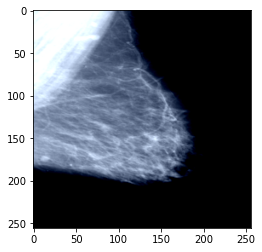

In [30]:
plt.imshow(  unnormalize(batch['image'][3]).permute(1, 2, 0)  )
# plt.imshow(  batch['image'][0] )


In [31]:
batch['mask'][0].min()

tensor(0.)

In [32]:
 unnormalize(batch['mask'][0]).shape

torch.Size([3, 256, 256])

In [33]:
batch['mask'][0].permute(1, 2, 0).squeeze(axis=2).shape

torch.Size([256, 256])

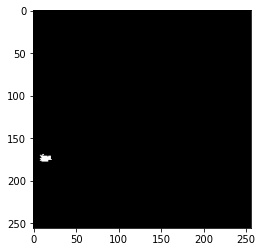

In [34]:
# plt.imshow(  255*unnormalize(batch['mask'][0]).permute(1, 2, 0)  , cmap='gray')
plt.imshow( batch['mask'][3].permute(1, 2, 0).squeeze(axis=2), cmap='gray'  )

In [35]:
torch.sigmoid(outputs.cpu()[0]).shape

torch.Size([1, 256, 256])

In [36]:
255*torch.sigmoid(outputs.cpu()[0]).max()

tensor(254.9349)

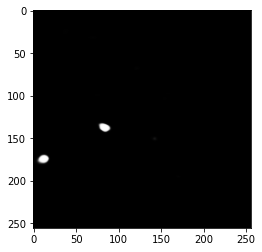

In [37]:
#plt.imshow(  unnormalize(torch.sigmoid(outputs.cpu()[0])).permute(1, 2, 0)  )
plt.imshow(  torch.sigmoid(outputs.cpu()[3]).permute(1, 2, 0).squeeze(axis=2), cmap='gray'  )
# plt.imshow(  batch['image'][0] )


In [38]:
my_mask= batch['mask'][0].permute(1, 2, 0).squeeze(axis=2)
my_mask.max()

tensor(1.)

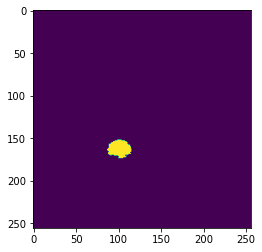

In [39]:
plt.imshow(255*cv_my_mask)

In [40]:
cv_image.shape

NameError: name 'cv_image' is not defined

In [41]:
batch['mask'][0].permute(1, 2, 0).type(torch.uint8).numpy().shape

(256, 256, 1)

In [42]:
from torchvision.utils import save_image
save_image(unnormalize(batch['image'][0]), 'temp_img.png')

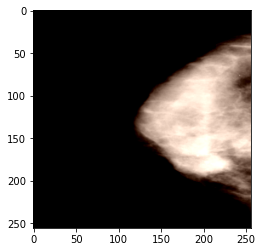

In [43]:
im = cv2.imread('temp_img.png')
plt.imshow(im)

In [44]:
import cv2
import numpy as np
# cv_image = unnormalize(batch['image'][0]).permute(1, 2, 0).numpy()
# cv_image_main = cv_image[:,:,0]
cv_image_main = im
cv_my_mask= batch['mask'][0].permute(1, 2, 0).squeeze(axis=2).type(torch.uint8).numpy()

# cv_my_mask, _ = cv2.threshold(cv_my_mask, 127, 255, 0)
# cv_my_mask= batch['mask'][0].permute(1, 2, 0).type(torch.uint8).numpy()
# cv_my_mask= batch['mask'][0].permute(1, 2, 0).squeeze(axis=2).numpy()

# Dictionary giving RGB colour for label (segment label) - label 1 in red, label 2 in yellow
# RGBforLabel = { 1:(0,255,0), 2:(0,255,255) }

# Find external contours
#_,contours,_ = cv2.findContours(cv_my_mask,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
contours,_ = cv2.findContours(cv_my_mask.astype(np.uint8),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
contours_pred,_ = cv2.findContours(cv_my_mask.astype(np.uint8),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)

_ = cv2.drawContours(im, contours, -1, (0,255,0), 1)


In [76]:
#my_mask= batch['mask'][0].permute(1, 2, 0).squeeze(axis=2).type(torch.uint8).numpy()
my_mask= batch['mask'][0]#
my_mask = my_mask.mean(1,keepdim=True)  #transform from [batch_size, 3, size, size] to [batch,size, 1, size, size]
            # inputs = inputs.to(device)
            # mask = mask.to(device)
dice_score(outputs.cpu()[0], my_mask)

tensor([0.0114])

In [68]:
outputs.cpu()[0].shape

torch.Size([1, 256, 256])

In [70]:
my_mask.shape

torch.Size([1, 256, 256])

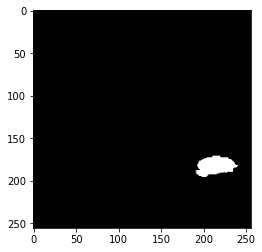

In [67]:
my_mask= batch['mask'][0]#
my_mask = my_mask.permute(1, 2, 0).squeeze(axis=2).type(torch.uint8).numpy()
plt.imshow(my_mask, cmap='gray')
# my_mask.shape

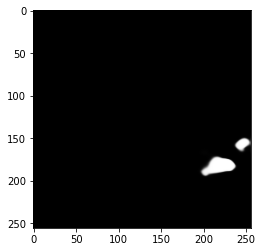

In [74]:
plt.imshow(torch.sigmoid(outputs.cpu()[0]).permute(1, 2, 0).squeeze(axis=2), cmap='gray' )
# plt.imshow(outputs.cpu()[0].permute(1, 2, 0).squeeze(axis=2), cmap='gray' )

In [80]:
my_mask= batch['mask'][0]#
# my_mask = my_mask.mean(1,keepdim=True)  #tran
my_mask.shape

torch.Size([1, 256, 256])

In [83]:
my_output = outputs.cpu()[0]
print(my_output.shape)

torch.Size([1, 256, 256])


In [91]:
my_output.min()

tensor(-56.0131)

In [92]:
"""input and target should be FloatTensor where the first dimension is the batch."""
eps = 1e-8 
target = my_mask
myinput = my_output
myinput = torch.sigmoid(my_output)

intersection = (myinput * target).flatten(1).sum(1)
sum_both = myinput.flatten(1).sum(1) + target.flatten(1).sum(1)
dice =  (2 * intersection + eps) / (sum_both + eps)
print(dice)

tensor([0.6972])


TypeError: order must be str, not int

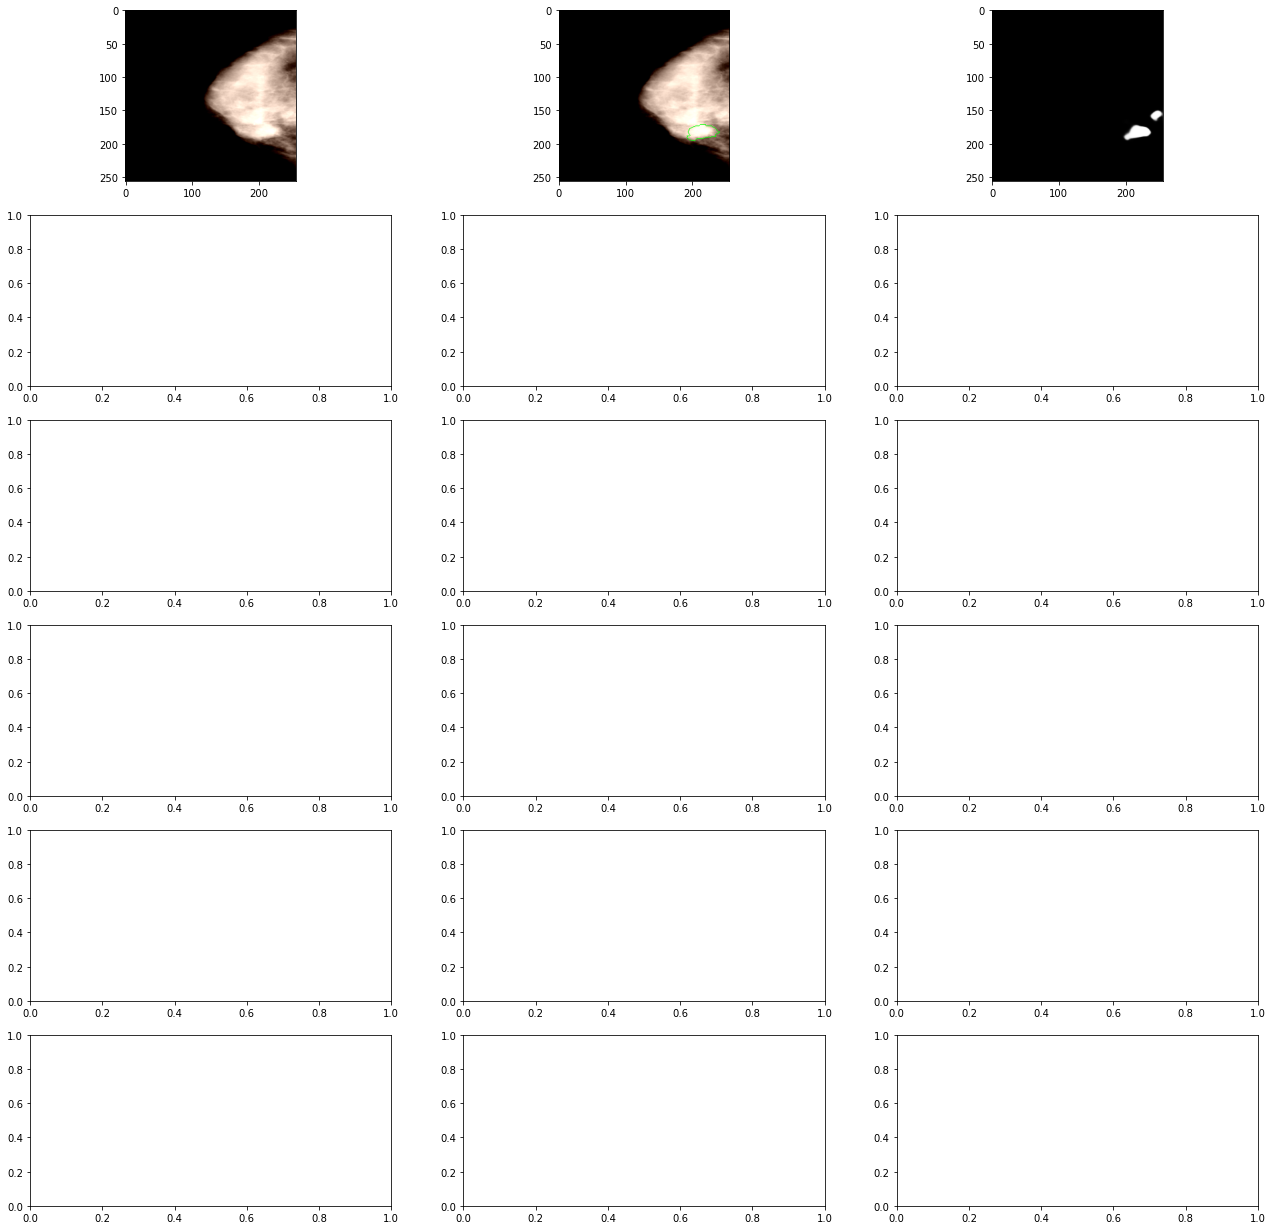

In [48]:
num_img = 6
fig, ax = plt.subplots(nrows=num_img, ncols=3, figsize = (22, 22))

for i in range(num_img):
    
    save_image(unnormalize(batch['image'][i]), 'temp_img.png')
    im = cv2.imread('temp_img.png')
    ax[i][0].imshow(im)
    
    my_mask= batch['mask'][i].permute(1, 2, 0).squeeze(axis=2).type(torch.uint8).numpy()
    
    contours,_ = cv2.findContours(my_mask,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
    _ = cv2.drawContours(im, contours, -1, (0,255,0), 1)
    ax[i][1].imshow(im)
    ax[i][2].imshow(torch.sigmoid(outputs.cpu()[i]).permute(1, 2, 0).squeeze(axis=2), cmap='gray' )  #pred
    print(dice_score(outputs.cpu()[i], my_mask))

plt.tight_layout()

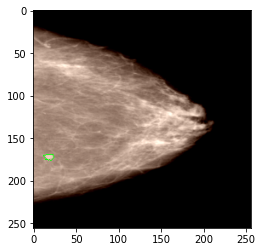

In [46]:
plt.imshow(im)

# Training log

In [20]:
df_seg = pd.read_csv("output/segmentation/bs8_size256_ep30_lr0.0001_bcew0.5/train_log.csv")

In [21]:
df_seg.head(10)

,Unnamed: 0,loss_train,dice,iou,epoch
0,0,78.564753,0.001019,0.000510,0
1,1,57.489140,0.000872,0.000436,1
2,2,54.023063,0.000765,0.000383,2
3,3,52.267006,0.000224,0.000112,3
4,4,51.038906,0.000364,0.000182,4
5,5,50.271029,0.001692,0.000847,5
6,6,49.796511,0.001303,0.000652,6
7,7,49.147764,0.000667,0.000334,7
8,8,47.532839,0.000883,0.000442,8
9,9,47.504986,0.000930,0.000465,9


In [53]:
df_seg.max()

Unnamed: 0    29.000000
loss_train    78.564753
dice           0.001692
iou            0.000847
epoch         29.000000
dtype: float64

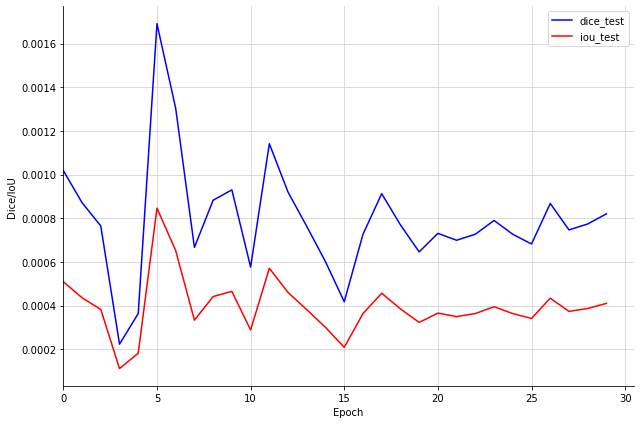

In [22]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9, 6))

line1 = ax.plot(df_seg['epoch'], df_seg['dice'], color="blue", label="dice_test")
line1 = ax.plot(df_seg['epoch'], df_seg['iou'], color="red", label="iou_test")
# line2 = ax.plot(x, y_val, color="red", label="val")

# Nicer visuals.
# ax.set_title('')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid(b=True, which="major", axis="both", color="#d3d3d3", linestyle="-")
ax.grid(b=True, which="minor", axis="both", color="#e7e7e7", linestyle="dashed")
ax.set_xlabel("Epoch")
ax.set_ylabel("Dice/IoU")
# ax.xaxis.set_ticks(np.arange(xtick_range[0], xtick_range[1], xtick_range[2]))
# ax.xaxis.set_minor_locator(MultipleLocator(5))
ax.set_xlim(left=0)
# ax.yaxis.set_ticks(np.arange(ytick_range[0], ytick_range[1], ytick_range[2]))
# ax.yaxis.set_minor_locator(MultipleLocator(0.01))
ax.patch.set_alpha(0)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels, loc="best")

# Save graph
save_path = True
plt.tight_layout()
if save_path:
    # plt.savefig(fname=save_path, dpi=300)
    plt.savefig(fname=os.path.join(save_log_path, 'dice_iou.png'), dpi=300)
    

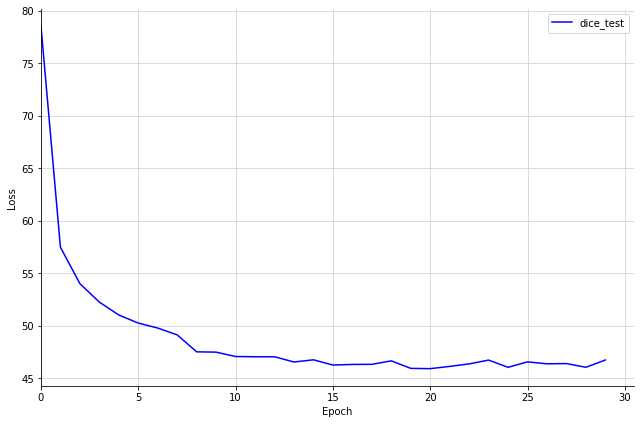

In [23]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9, 6))

line1 = ax.plot(df_seg['epoch'], df_seg['loss_train'], color="blue", label="dice_test")
# line2 = ax.plot(x, y_val, color="red", label="val")

# Nicer visuals.
# ax.set_title('')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid(b=True, which="major", axis="both", color="#d3d3d3", linestyle="-")
ax.grid(b=True, which="minor", axis="both", color="#e7e7e7", linestyle="dashed")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
# ax.xaxis.set_ticks(np.arange(xtick_range[0], xtick_range[1], xtick_range[2]))
# ax.xaxis.set_minor_locator(MultipleLocator(5))
ax.set_xlim(left=0)
# ax.yaxis.set_ticks(np.arange(ytick_range[0], ytick_range[1], ytick_range[2]))
# ax.yaxis.set_minor_locator(MultipleLocator(0.01))
ax.patch.set_alpha(0)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels, loc="best")

# Save graph
save_path = True
plt.tight_layout()
if save_path:
    # plt.savefig(fname=save_path, dpi=300)
    plt.savefig(fname=os.path.join(save_log_path, 'loss.png'), dpi=300)
    
